In [1]:
# Imports, as always...
from tqdm.notebook import tqdm
import numpy as np
from os import makedirs, path

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import ParameterVector

# Classical ML.
import torch
from torch.nn import Module, Sequential
from torch.optim import Adam
from torch import manual_seed
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Quantum ML.
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_machine_learning import __version__ as qml_version
from qiskit_algorithms import __version__ as alg_version
from torch import __version__ as torch_version

# Plotting.
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

# Random seed setting.
seed = 42
algorithm_globals.random_seed = seed
np.random.seed(seed)
manual_seed(seed)

# Device management.
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Package versions (ignoring packages that obviously won't be a problem).
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit_machine_learning', qml_version), ('qiskit_algorithms', alg_version), ('numpy', np.__version__), ('torch', torch_version)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit                  : 1.1.1
qiskit_machine_learning : 0.7.2
qiskit_algorithms       : 0.3.0
numpy                   : 1.24.3
torch                   : 2.3.1


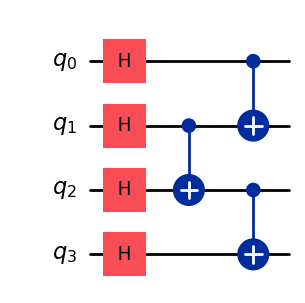

In [4]:
# Setting the unknown unitary to be learnt.
U = QuantumCircuit(4)
U.h(0), U.h(1), U.h(2), U.h(3)
U.cx(1, 2), U.cx(0, 1), U.cx(2, 3)

U.draw('mpl', style='iqp')

# Variational Local Inversions

I personally find the algorithm for obtaining local inversions in Huang et al. (2024) to be underwhelming and, frankly, not as practically useful as it would have you believe. We wonder if it would instead be more general and/or efficient to use a variational algorithm for finding local inversions. Following this, sewing can probably be done in the same way as before.

Suppose I have an unknown unitary $U$, and I want to learn a set of parameters $\theta_i$ for a given parameterised unitary $V$ so that $V(\theta_i)$ will invert the action of $U$ on qubit $i$ (with no regard given to what happens to the other qubits). So, for an arbitrary state $|\psi\rangle=|\psi_1\dots\psi_i\dots\psi_n\rangle$, the action of applying $U$ then $V(\theta_i)$ gives $V(\theta_i)U|\psi_1\dots\psi_i\dots\psi_n\rangle=|\phi_1\dots\psi_i\dots\phi_n\rangle$, and hence the $i$-th qubit has been preserved. More generally, we can consider locally inverting a *set* of qubits $S\subseteq\{1,\dots,n\}$ by finding a parameterisation $\theta_S$.

**I think this is job for a Quantum Neural Network (QNN)**. It all reminds me very much of [this](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html).

![QNN Diagram](./figures/qiskit-qnn-diagram.png)

## As a Quantum Neural Network

QNNs generally have three distinct parts: (1) *data loading* via some feature map applied to a classical set of inputs, which serves to encode the classical data as quantum states; (2) *data processing* via  a parameterised quantum circuit -- an ansatz -- whose tunable parameters (or 'weights') are optimised such that they minimise the cost function; and (3) *measurement* collapsing the output back into the classical world.

For our problem, we can let our unknown unitary $U$ be our feature map, with a dataset of randomised inputs $\mathbf{x}_i\in\{0, 1, 2, 3, 4, 5\}^n$ denoting a tensor product over the six single-qubit stabiliser states. Then, obviously, our paramaterised circuit is $V(\theta_S)$, for which the weights $\theta_S$ must be optimised so that $V(\theta_S)$ (approximately) locally inverts $U$ at the $i$-th qubit for all $i\in S$.

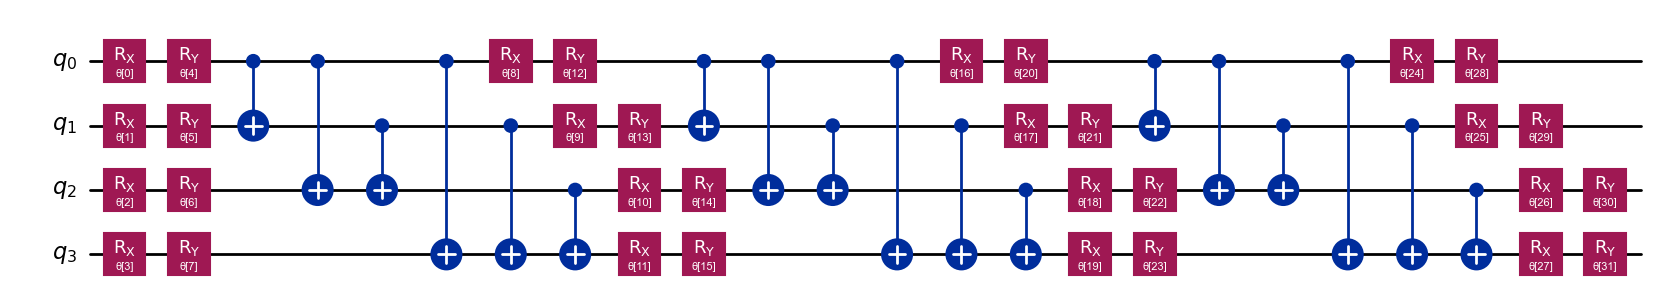

In [5]:
# Define an ansatz.
def build_ansatz(n_qubits, ansatz_reps):
    return TwoLocal(num_qubits=n_qubits, rotation_blocks=['rx', 'ry'], entanglement_blocks='cx', entanglement='full', reps=ansatz_reps, name='Ansatz')

# Demo.
build_ansatz(U.num_qubits, ansatz_reps=3).decompose().draw('mpl', style='iqp')

In [6]:
# Define the full circuit.
def build_experiment_circuit(U, ansatz_reps, target_qubits):
    # Instantiate a new circuit with classical register for measurement.
    q_reg = QuantumRegister(U.num_qubits + len(target_qubits) + 1)
    c_reg = ClassicalRegister(1)
    circuit = QuantumCircuit(q_reg, c_reg)
    
    # Prepare an input state (parameterised) consistent between the two sets of qubits.
    input_parameters = ParameterVector('in', 2 * U.num_qubits)
    for i in range(U.num_qubits):
        circuit.r(theta=input_parameters[2 * i], phi=input_parameters[2 * i + 1], qubit=i)
        if i in target_qubits: circuit.r(theta=input_parameters[2 * i], phi=input_parameters[2 * i + 1], qubit=U.num_qubits + i - 1)
        
    # Barrier for clarity.
    circuit.barrier()
        
    # Add U.
    U_copy = U.copy()
    circuit.compose(U_copy, inplace=True)
    
    # Barrier for clarity.
    circuit.barrier()
    
    # Then add the ansatz.
    ansatz = build_ansatz(U.num_qubits, ansatz_reps=ansatz_reps)
    circuit.compose(ansatz, inplace=True)
    
    # Barrier for clarity.
    circuit.barrier()
    
    # SWAP test for loss business.
    aux_idx = circuit.num_qubits - 1
    circuit.h(aux_idx)
    
    for i, q in enumerate(target_qubits):
        circuit.cswap(control_qubit=aux_idx, target_qubit1=q, target_qubit2=U.num_qubits+i)
        
    circuit.h(aux_idx)
    circuit.measure(aux_idx, c_reg[0])
    
    # Return the circuit, the input parameters, and the weight parameters.
    return circuit, input_parameters, ansatz.parameters

In [7]:
# Using an identity interpret as the mapping of the QNNs output.
def identity_interpret(x): return x

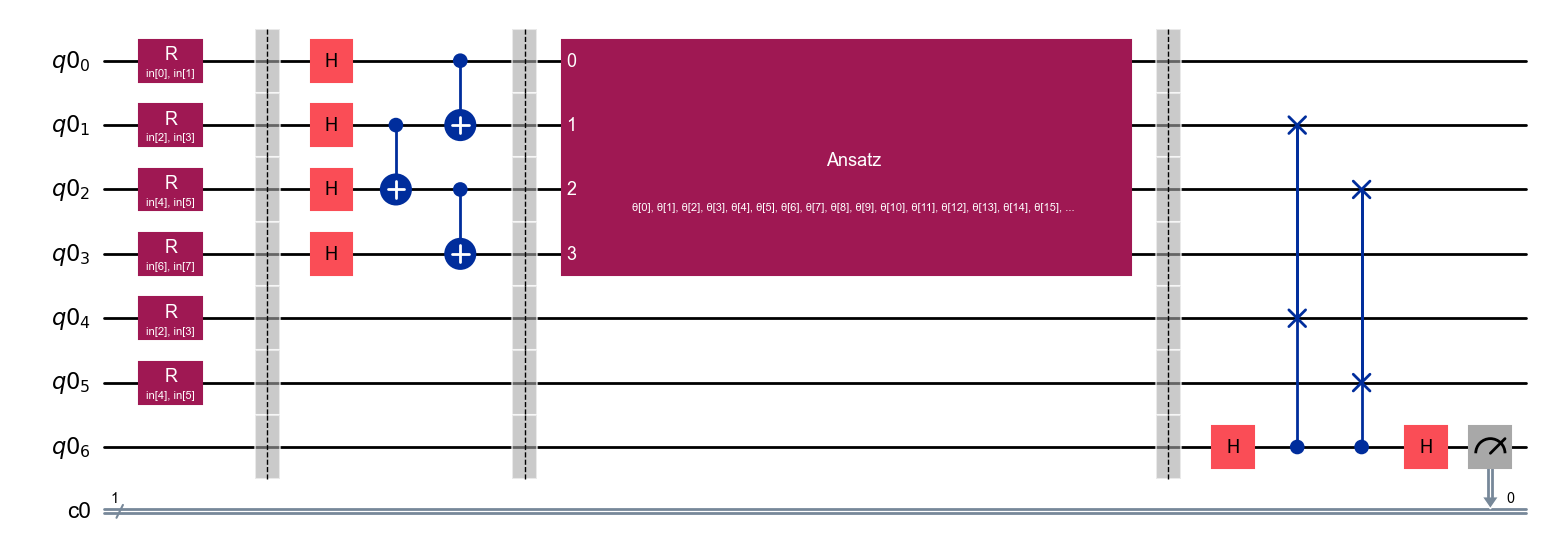

In [8]:
# Build a circuit and get its parameters.
experiment_circuit, input_parameters, weight_parameters = build_experiment_circuit(U, ansatz_reps=10, target_qubits=[1, 2])
experiment_circuit.draw('mpl', style='iqp')

In [12]:
# The QNN object.
qnn = SamplerQNN(
    circuit=experiment_circuit,
    input_params=input_parameters,
    weight_params=weight_parameters,
    interpret=identity_interpret,
    output_shape=2,
    input_gradients=True
)

# Demo.
n_samples = 10
qnn.forward(
    input_data=algorithm_globals.random.random(size=(n_samples, len(input_parameters))),
    weights=algorithm_globals.random.random(len(weight_parameters))
)

array([[0.63748738, 0.36251262],
       [0.60557206, 0.39442794],
       [0.54295167, 0.45704833],
       [0.62110897, 0.37889103],
       [0.65726476, 0.34273524],
       [0.57341574, 0.42658426],
       [0.55661399, 0.44338601],
       [0.57063578, 0.42936422],
       [0.66808611, 0.33191389],
       [0.61668944, 0.38331056]])

## Cost Function

It sure would be neat if the cost function could be defined to maximise the fidelity between the input and output state, when ignoring (e.g. tracing out) any qubits not in $S$. Section 4 of [this Qiskit tutorial](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html), or the cost function in [this paper](https://arxiv.org/abs/1612.02806) may be of use (both are concerning themselves with autoencoders, but the loss should be very similar). 

Let $S$ be the system within which we would like $V(\theta_S)$ to locally invert $U$, and $\bar S$ be the complementary system containing the remaining qubits, preserved or otherwise. Then our goal is $\max F(|\psi_{S}\rangle\langle\psi_{S}|,\rho^\text{out}_{S})$, where $|\psi_S\rangle\langle\psi_S|=\text{tr}_{\bar S}[|\psi\rangle\langle\psi|]$ and $\rho_S^\text{out}=\text{tr}_{\bar S}[V^\dag(\theta_S)U^\dag|\psi\rangle\langle\psi|UV(\theta_S)]$. Computing this is not easy, however, and scales poorly with a scaling system, so an alternative is suggested...

### SWAP test

A common procedure for comparing two states is the SWAP test (a.k.a. "distance measure", "kernel method", "inner product"), which consists of applying CNOT gates to each qubit (see [the wiki](https://en.wikipedia.org/wiki/Swap_test)). We want a SWAP test over multiple qubits.

The squared inner product between the compared states is approximated by $1-2L/M$, where $L$ is the number of $|1\rangle$ outcomes measured, and $M$ is the total number of tests. To maximise the inner product (to make the states as similar as possible), we must minimise $L/M$. This will be our loss.

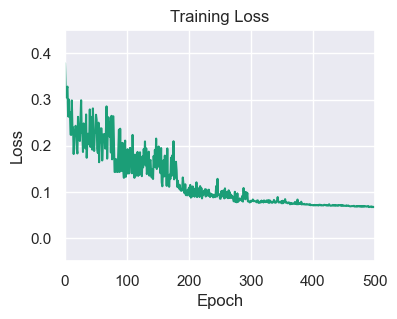

In [13]:
# It would appear that the only way to do loss tracking is to define a list outside the loss function?
loss_values = []
max_iters = 500

# Define the loss (cost) function according to the SWAP test.
def loss_fn(qnn, inputs, weights, plot=True):
    # We care only about the probability to measure outcome 1 on the single-qubit classical register.
    loss = np.mean(qnn.forward(input_data=inputs, weights=weights)[:, 1])
    loss_values.append(loss)
    
    # Plotting.
    clear_output(wait=True)
    plt.plot(range(len(loss_values)), loss_values)
    
    # Beautification.
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(-0.05, .45)
    plt.xlim(0, max_iters)
    
    plt.show()
    
    return loss
    
# Random input parameters.
n_samples = 100
xs = algorithm_globals.random.random(size=(n_samples, len(input_parameters)))
#angles = [0, np.pi, -np.pi]
#xs = np.random.choice(angles, size=(n_samples, len(input_parameters)))
    
# Optimiser and starting weights.
optimiser = COBYLA(maxiter=max_iters)
initial_weights = algorithm_globals.random.random(len(weight_parameters))

# Do the thing.
plt.rcParams['figure.figsize'] = (4, 3)
optimal_result = optimiser.minimize(lambda ws : loss_fn(qnn, xs, ws), x0=initial_weights)

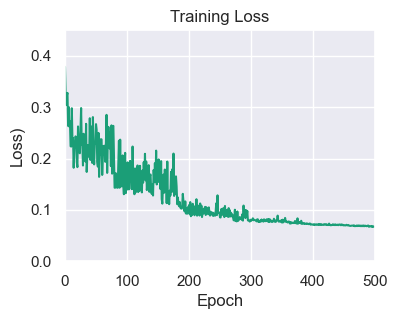

In [22]:
# Let's have that drawn again, but we'll save it this time and everything.

# Plot.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(range(len(loss_values)), loss_values)
    
# Beautification.
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss)')
ax.set_xlim(0, len(loss_values))
ax.set_ylim(.0, .45)

# Save the thing.
plt.savefig('./figures/qnn-loss-curve-100-samples.pdf', bbox_inches='tight')

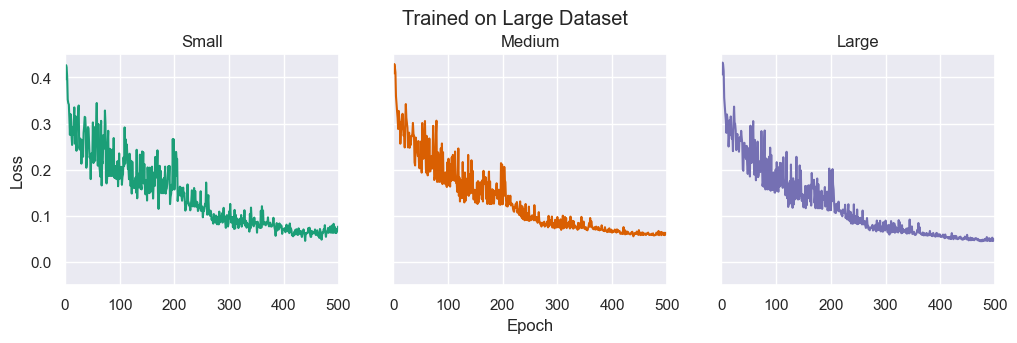

In [54]:
# Let's have a look at generalisation.
xs_small = algorithm_globals.random.random(size=(1, len(input_parameters)))
xs_medium = algorithm_globals.random.random(size=(10, len(input_parameters)))
xs_large = algorithm_globals.random.random(size=(100, len(input_parameters)))
datasets = [xs_small, xs_medium, xs_large]

max_iters = 500

# Colour palette.
palette = sns.color_palette('Dark2', n_colors=3)

losses = {0 : [], 1 : [], 2 : []}
def loss_fn_with_val(qnn, dataset_idx, weights, plot=True):
    # The train loss, which we optimise weights based on.
    train_loss = np.mean(qnn.forward(input_data=datasets[dataset_idx], weights=weights)[:, 1])
    losses[dataset_idx].append(train_loss)
    
    # The val loss, evaluating on the other datasets to understand generality.
    val_1_loss = np.mean(qnn.forward(input_data=datasets[(dataset_idx + 1) % 3], weights=weights)[:, 1])
    losses[(dataset_idx + 1) % 3].append(val_1_loss)
    val_2_loss = np.mean(qnn.forward(input_data=datasets[(dataset_idx + 2) % 3], weights=weights)[:, 1])
    losses[(dataset_idx + 2) % 3].append(val_2_loss)
    
    # Plotting.
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey='row')
    for i, ax in enumerate(axes.flatten()): ax.plot(range(len(losses[i])), losses[i], color=palette[i])
    
    # Beautification.
    fig.suptitle(f'Trained on {["Small", "Medium", "Large"][dataset_idx]} Dataset', y=1.03)
    axes.flatten()[0].set_title('Small')
    axes.flatten()[1].set_title('Medium')
    axes.flatten()[2].set_title('Large')
    axes.flatten()[1].set_xlabel('Epoch')
    axes.flatten()[0].set_ylabel('Loss')
    axes.flatten()[0].set_ylim(-0.05, .45)
    axes.flatten()[0].set_xlim(0, max_iters)
    axes.flatten()[1].set_xlim(0, max_iters)
    axes.flatten()[2].set_xlim(0, max_iters)
    
    plt.show()
    
    return train_loss

losses_by_set = {}
weights_by_set = {}
for i in range(len(datasets)):
    losses = {0 : [], 1 : [], 2 : []}
    
    # The QNN object.
    qnn = SamplerQNN(
        circuit=experiment_circuit,
        input_params=input_parameters,
        weight_params=weight_parameters,
        interpret=identity_interpret,
        output_shape=2,
        input_gradients=True
    )
    
    # Optimiser and starting weights.
    optimiser = COBYLA(maxiter=max_iters)
    initial_weights = algorithm_globals.random.random(len(weight_parameters))
    
    # Do the thing.
    optimal_result = optimiser.minimize(lambda ws : loss_fn_with_val(qnn, i, ws), x0=initial_weights)
    weights_by_set[i] = optimal_result.x
    losses_by_set[i] = losses

In each iteration... we randomly generate a set of $N$ input samples $|\psi_i\rangle$, and portion them into batches of size $B$. For now, we'll go with $B=1$ until we know it's working. Then, in each batch... 
1. Prepare the $|\psi_i\rangle$ together with a copy of the qubits in the target set $S$ and an auxiliary qubit initialised in $|0\rangle$ to yield an input to the circuit $|\psi_i\rangle\otimes|\psi_S\otimes|0\rangle$.
2. Perform $U$ followed by $V(\theta_S)$ on the first $n$ qubits to yield $UV(\theta_S)|\psi\rangle\otimes|\psi_S\rangle\otimes|0\rangle$. Discard the qubits in $UV(\theta_S)|\psi\rangle$ not in $S$ to yield $(UV(\theta_S)|\psi\rangle)_S\otimes|\psi_S\rangle\otimes|0\rangle$.
3. Perform a SWAP test between $(UV(\theta_S)|\psi\rangle)_S$ and $|\psi_S\rangle$, using the auxiliary qubit as the control to be measured. We require $O(1/\varepsilon^2)$ runs of the test to estimate the squared inner produce between them to within $\varepsilon$ additive error.
4. Update the weights $\varepsilon$ according to the loss, determined as before by the estimate of the squared inner product.

In [57]:
losses_by_set[0].keys()

dict_keys([0, 1, 2])

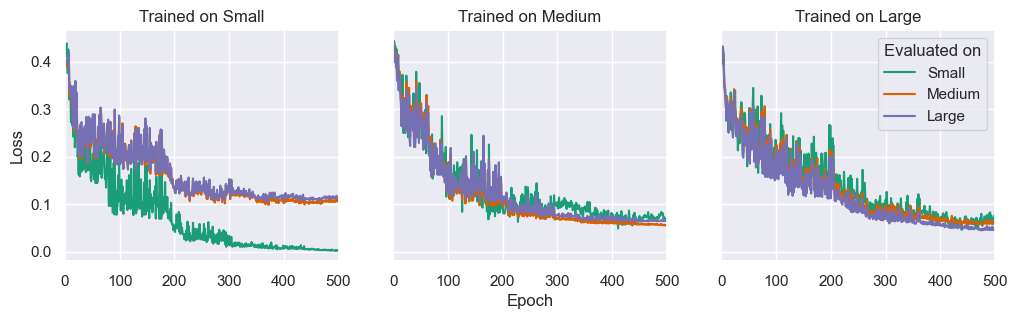

In [73]:
# Plot.
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)
palette = sns.color_palette('Dark2', n_colors=3)

epochs = range(len(losses_by_set[0][0]))
for i, ax in enumerate(axes):
    ax.plot(epochs, losses_by_set[i][0], color=palette[0], label='Small')
    ax.plot(epochs, losses_by_set[i][1], color=palette[1], label='Medium')
    ax.plot(epochs, losses_by_set[i][2], color=palette[2], label='Large')
    
# Beautification.
axes[0].set_title('Trained on Small')
axes[1].set_title('Trained on Medium')
axes[2].set_title('Trained on Large')
axes[-1].legend(title='Evaluated on')
axes[0].set_xlim(0, len(epochs))
axes[0].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

plt.savefig('./figures/qnn-loss-curve-by-dataset-size.pdf', bbox_inches='tight')

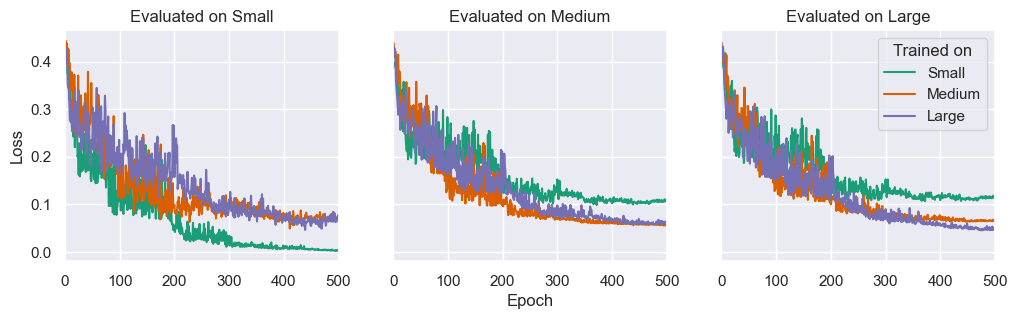

In [74]:
# Plot.
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)
palette = sns.color_palette('Dark2', n_colors=3)

epochs = range(len(losses_by_set[0][0]))
for i, ax in enumerate(axes):
    ax.plot(epochs, losses_by_set[0][i], color=palette[0], label='Small')
    ax.plot(epochs, losses_by_set[1][i], color=palette[1], label='Medium')
    ax.plot(epochs, losses_by_set[2][i], color=palette[2], label='Large')
    
# Beautification.
axes[0].set_title('Evaluated on Small')
axes[1].set_title('Evaluated on Medium')
axes[2].set_title('Evaluated on Large')
axes[-1].legend(title='Trained on')
axes[0].set_xlim(0, len(epochs))
axes[0].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

plt.savefig('./figures/qnn-loss-curve-by-dataset-size-alternative.pdf', bbox_inches='tight')

## As a Torch-connected QNN

We'd like to have more control over batches, variable input samples, gradient calculation, etc. so it would be nice to use `TorchConnector` to give us all these things -- hopefully we can train a QNN through a Torch connector as we would train any Torch model. 

In [22]:
# Fibonacci sphere algorithm for sampling an even distribution of points on the unit sphere as a pair of angles.
# See https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
def sample_input_angles(n_points):
    # Define the golden angle in radians.
    golden_ratio = np.pi * (np.sqrt(5) - 1)
    
    angles = []
    for i in range(n_points):
        # Generate (x, y, z) co-ordinates.
        y = 1 - (i / (n_points - 1)) * 2
        r = np.sqrt(1 - y ** 2)
        x = np.cos(golden_ratio * i) * r
        z = np.sin(golden_ratio * i) * r
        
        # Convert to polar angles.
        theta = np.arctan2(y, x)
        phi = np.arccos(z)
        
        # Append.
        angles.append([theta, phi])
        
    # Return as a numpy array.
    return np.array(angles)

# Build a dataset of N n-qubit states over an unbiased distribution.
def sample_xs(N, n, n_points=500):
    # Generate the set of angles.
    angles = sample_input_angles(n_points)
    
    # Return N uniformly randomly sampled sets of angles.
    return np.array([
        np.array(angles[np.random.choice(angles.shape[0], size=n, replace=True)]).ravel() for _ in range(N)
    ])

In [95]:
# Loss function.
class Loss(Module):
    def __init__(self):
        super(Loss, self).__init__()
        
    def forward(self, x):
        # Take the mean probability to measure outcome 1.
        # Single-size batches don't have two dimensions, so treat those differently.
        if x.dim() == 1: return x[1]
        else: return torch.mean(x[:, 1])

In [146]:
# Training step (i.e. one epoch).
def train_step(model, loader, optimiser, criterion):
    # Use train mode.
    model.train()
    
    # Track the running loss.
    running_loss = .0
    
    for xs in tqdm(loader):
        xs = xs.to(device)
        
        # Zero gradients.
        optimiser.zero_grad()
        
        # Run and estimate outcome distribution.
        outcome_dist = model(xs)
        
        # Compute loss.
        loss = criterion(outcome_dist)
        running_loss += loss.item()
        
        # Compute gradients and adjust weights.
        loss.backward()
        optimiser.step()
        
    # Return average loss in each batch over the epoch.
    return running_loss / len(loader)
        
# Evaluation step.
def evaluate(model, loader, criterion):
    # Use evaluation mode.
    model.eval()
    
    # Track running loss.
    running_loss = .0
    
    # No gradient tracking in evaluation.
    with torch.no_grad():
        for xs in loader:
            xs = xs.to(device)
            
            # Run and estimate outcome distribution.
            outcome_dist = model(xs)
            
            # Compute loss.
            loss = criterion(outcome_dist)
            running_loss += loss.item()
            
    # Return average loss in each batch over the loader.
    return running_loss / len(loader)

# Full training routine.
# Remember the training statistics, just in case someone feels like plotting it.
train_losses, val_losses = [], []
def train(model, train_loader, val_loader, n_epochs, lr=1e-3, live_plot=True, save_file_name='model_dict', save_dir=None):
    if save_dir: makedirs(save_dir, exist_ok=True)
    
    # Optimiser and loss function.
    optimiser = Adam(params=model.parameters(), lr=lr)
    criterion = Loss()
    
    # Track the best validation loss to recover the best model weights post-training.
    best_val_loss = np.inf
    best_state = model.state_dict()
    
    for _ in tqdm(np.arange(1, n_epochs + 1), desc='Training'):
        # Train step and evaluation.
        train_loss = train_step(model, train_loader, optimiser, criterion)
        val_loss = evaluate(model, val_loader, criterion)
        
        # Store the stats.
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Update to the bests.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            
            # Save.
            if save_dir: torch.save(best_state, path.join(save_dir, f'{save_file_name}.pt'))
            
        # Plot.
        if live_plot:
            clear_output(wait=True)
            palette = sns.color_palette('Dark2', n_colors=2)
            plt.plot(range(len(train_losses)), train_losses, color=palette[0], label='Train')
            plt.plot(range(len(val_losses)), val_losses, color=palette[1], label='Val')
            
            # Beautification.
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.ylim(-0.05, .45)
            plt.xlim(0, n_epochs)
            plt.legend()
            
            plt.show()

In [153]:
# The circuit and parameters.
experiment_circuit, input_parameters, weight_parameters = build_experiment_circuit(U, ansatz_reps=5, target_qubits=[1, 2])

# The QNN object.
qnn = SamplerQNN(
    circuit=experiment_circuit,
    input_params=input_parameters,
    weight_params=weight_parameters,
    interpret=identity_interpret,
    output_shape=2,
    input_gradients=True
)

# Explicitly declare initial weights (else they will be uniformly randomly sampled from [-1, 1]).
initial_weights = .1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)

# Chuck it all into a Torch connector.
model = TorchConnector(qnn, initial_weights=initial_weights)
model = model.to(device)

# Generate a dataset.
xs = sample_xs(N=100, n=U.num_qubits, n_points=10000)

# Train test split.
test_size, val_size = .25, .15
xs_train, xs_test = train_test_split(xs, test_size=test_size, shuffle=True)
xs_train, xs_val = train_test_split(xs_train, test_size=val_size, shuffle=True)

# Into Dataloaders.
batch_size = 16
n_workers = 1
train_dataloader = DataLoader(xs_train, shuffle=True, batch_size=batch_size, num_workers=n_workers)
val_dataloader = DataLoader(xs_val, shuffle=True, batch_size=batch_size, num_workers=n_workers)
test_dataloader = DataLoader(xs_test, shuffle=True, batch_size=batch_size, num_workers=n_workers)

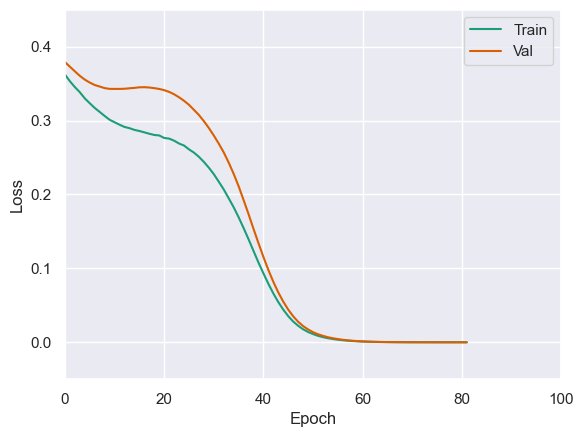

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [154]:
# Remember the training statistics, just in case someone feels like plotting it.
train_losses, val_losses = [], []

# Train!
train(model, train_dataloader, val_dataloader, n_epochs=100, lr=1e-2)

In [158]:
list(zip(train_losses, val_losses))

[(0.36205603927373886, 0.37903866171836853),
 (0.353050597012043, 0.37273868918418884),
 (0.34515758603811264, 0.3664572238922119),
 (0.3381843939423561, 0.3603983521461487),
 (0.3298580124974251, 0.3552905321121216),
 (0.3233194127678871, 0.35131198167800903),
 (0.3169878050684929, 0.34801429510116577),
 (0.31159693002700806, 0.3459794521331787),
 (0.30615324527025223, 0.34383678436279297),
 (0.3010058104991913, 0.34282898902893066),
 (0.2976621240377426, 0.34278154373168945),
 (0.2943348288536072, 0.34276801347732544),
 (0.29131852090358734, 0.3429969251155853),
 (0.28966333717107773, 0.34360939264297485),
 (0.2873348966240883, 0.3441721796989441),
 (0.28582562506198883, 0.3449453115463257),
 (0.2840111628174782, 0.34508833289146423),
 (0.28211989253759384, 0.3446767330169678),
 (0.2804609537124634, 0.3437952697277069),
 (0.279799185693264, 0.3427366614341736),
 (0.2764362059533596, 0.3410661220550537),
 (0.27554117143154144, 0.33876174688339233),
 (0.2727143168449402, 0.335481882095

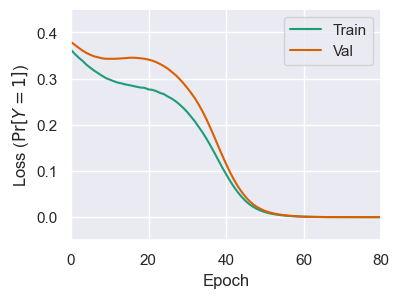

In [166]:
# A more beautiful plot.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

palette = sns.color_palette('Dark2', n_colors=2)
plt.plot(range(len(train_losses)), train_losses, color=palette[0], label='Train')
plt.plot(range(len(val_losses)), val_losses, color=palette[1], label='Val')

# Beautification.
plt.xlabel('Epoch')
plt.ylabel('Loss ($\\text{Pr}[Y=1]$)')
plt.ylim(-0.05, .45)
plt.xlim(0, 80)
plt.legend()

plt.savefig('./figures/torch-qnn-loss-curve.pdf', bbox_inches='tight')

In [172]:
# And what about over the test set?
Loss()(model(torch.tensor(xs_test)).detach()).item()

2.0613433662219904e-06

In [173]:
# Save the model manually (didn't do it in training -- whoopsies).
torch.save(model.state_dict(), './models/proof-of-concept/model_dict.pt')

## Multi-qubit SWAP Test as a Global Objective Function

Resources:
- https://arxiv.org/pdf/2205.07171
- https://quantumcomputing.stackexchange.com/questions/9775/swap-test-to-calculate-inner-product-with-qiskit-for-multi-qubit-states
- https://iopscience.iop.org/article/10.1088/2058-9565/abe458
- https://arxiv.org/abs/1805.02546

In [1]:
# Script imports to hide all of the above.
from scripts.utils import sample_n_states
from scripts.circuits import build_circuit
from scripts.learning import build_qnn_circuit, train_by_COBYLA, train_by_torch

In [2]:
# Unitary to be learnt.
n, d = 4, 4
U = build_circuit(n, d)

# Train and validation sets.
xs_train = sample_n_states(n_states=24, n_qubits=n)
xs_val = sample_n_states(n_states=16, n_qubits=n)

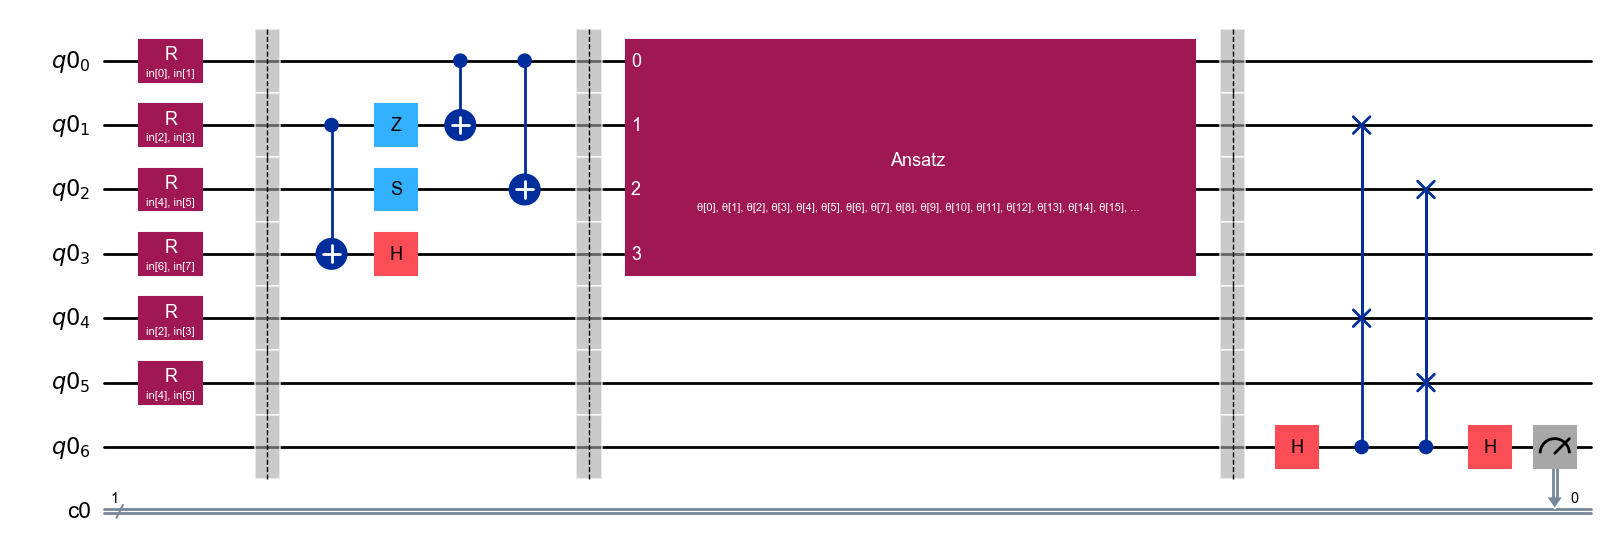

In [3]:
# With local SWAP tests...

# Build a circuit for the QNN from U.
target_qubits = [1, 2]
local_qnn_circuit, input_parameters, weight_parameters = build_qnn_circuit(U, ansatz_reps=5, target_qubits=target_qubits)

local_qnn_circuit.draw('mpl', style='iqp')

In [ ]:
# Define a QNN object. 
local_qnn = SamplerQNN(
    circuit=local_qnn_circuit,
    input_params=input_parameters,
    weight_params=weight_parameters,
    interpret=lambda x: x, 
    output_shape=2, 
    input_gradients=True
)

# Explicitly declare initial weights.
initial_weights = .1 * (2 * algorithm_globals.random.random(local_qnn.num_weights) - 1)

# Train.
train_by_COBYLA(local_qnn, xs_train, xs_val, n_epochs=300, initial_weights=initial_weights, live_plot=True)

In [4]:
# With global SWAP tests...

# Build a circuit for the QNN from U.
target_qubits = [1, 2]
global_qnn_circuit, input_parameters, weight_parameters = build_qnn_circuit(U, ansatz_reps=5, target_qubits=target_qubits, multi_swap=True)

global_qnn_circuit.draw('mpl', style='iqp')

[1, 2] [4, 5]


CircuitError: "Not sure how to combine these qubit arguments:\n [[Qubit(QuantumRegister(7, 'q1'), 6)], [Qubit(QuantumRegister(7, 'q1'), 1), Qubit(QuantumRegister(7, 'q1'), 2)], [Qubit(QuantumRegister(7, 'q1'), 4), Qubit(QuantumRegister(7, 'q1'), 5)]]\n"

In [ ]:
# Define a QNN object. 
global_qnn = SamplerQNN(
    circuit=global_qnn_circuit,
    input_params=input_parameters,
    weight_params=weight_parameters,
    interpret=lambda x: x, 
    output_shape=2, 
    input_gradients=True
)

# Train.
train_by_COBYLA(global_qnn, xs_train, xs_val, n_epochs=300, initial_weights=initial_weights, live_plot=True)

In [8]:
from qiskit.circuit import QuantumCircuit, QuantumRegister

q_reg = QuantumRegister(4)
q_reg[[1, 2]]

[Qubit(QuantumRegister(4, 'q4'), 1), Qubit(QuantumRegister(4, 'q4'), 2)]